In [ ]:
# This Jupyter notebook walks you through scraping LinkedIn posts from McKinsey & Company using Selenium in Python. 
# We'll scroll the page, extract post text and timestamps, and analyze for sustainability mentions.


In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
# Launch Chrome and Navigate to LinkedIn
chrome_options = Options()
# Comment this out if you want to see the browser
# chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--window-size=1280,800')

service = Service()  # Use default path if chromedriver is in PATH
driver = webdriver.Chrome(service=service, options=chrome_options)

# Navigate to McKinsey's LinkedIn posts page
driver.get("https://www.linkedin.com/company/mckinsey/posts/?feedView=all")

# Pause to log in manually
input("⏸ Please log in to LinkedIn in the opened browser, then press [Enter] to continue...")


⏸ Please log in to LinkedIn in the opened browser, then press [Enter] to continue... 


''

In [3]:
#testing the scraper 
SCROLL_PAUSE_TIME = 1  # seconds between scrolls
SCROLL_COUNT = 600  # adjust as needed

for i in range(600):  # start small for testing
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(SCROLL_PAUSE_TIME)
    print(f"✅ Scroll {i + 1} of {SCROLL_COUNT} complete")

print("Done scrolling.")

✅ Scroll 1 of 600 complete
✅ Scroll 2 of 600 complete
✅ Scroll 3 of 600 complete
✅ Scroll 4 of 600 complete
✅ Scroll 5 of 600 complete
✅ Scroll 6 of 600 complete
✅ Scroll 7 of 600 complete
✅ Scroll 8 of 600 complete
✅ Scroll 9 of 600 complete
✅ Scroll 10 of 600 complete
✅ Scroll 11 of 600 complete
✅ Scroll 12 of 600 complete
✅ Scroll 13 of 600 complete
✅ Scroll 14 of 600 complete
✅ Scroll 15 of 600 complete
✅ Scroll 16 of 600 complete
✅ Scroll 17 of 600 complete
✅ Scroll 18 of 600 complete
✅ Scroll 19 of 600 complete
✅ Scroll 20 of 600 complete
✅ Scroll 21 of 600 complete
✅ Scroll 22 of 600 complete
✅ Scroll 23 of 600 complete
✅ Scroll 24 of 600 complete
✅ Scroll 25 of 600 complete
✅ Scroll 26 of 600 complete
✅ Scroll 27 of 600 complete
✅ Scroll 28 of 600 complete
✅ Scroll 29 of 600 complete
✅ Scroll 30 of 600 complete
✅ Scroll 31 of 600 complete
✅ Scroll 32 of 600 complete
✅ Scroll 33 of 600 complete
✅ Scroll 34 of 600 complete
✅ Scroll 35 of 600 complete
✅ Scroll 36 of 600 complete
✅

In [4]:
#extract posts 

from selenium.webdriver.common.by import By
import pandas as pd

# Find all post containers
post_containers = driver.find_elements(By.CLASS_NAME, "feed-shared-update-v2")

post_texts = []
post_timestamps = []

for post in post_containers:
    try:
        # Post text
        text_elem = post.find_element(By.CLASS_NAME, "update-components-text")
        post_text = text_elem.text.strip()
    except:
        post_text = ""
        
#clean up timestamps
from selenium.webdriver.common.by import By
import re

post_texts = []
post_timestamps = []

for post in post_containers:
    # Extract post text
    try:
        text_elem = post.find_element(By.CLASS_NAME, "update-components-text")
        post_text = text_elem.text.strip()
    except:
        post_text = ""

    # Extract timestamp from the correct sub-description span
    try:
        sub_desc = post.find_element(By.CLASS_NAME, "update-components-actor__sub-description")
        time_span = sub_desc.find_element(By.XPATH, './/span[@aria-hidden="true"]')
        timestamp_raw = time_span.text.strip()
        match = re.search(r'\d+[a-z]+', timestamp_raw)  # e.g., "2mo", "1y"
        post_timestamp = match.group(0) if match else timestamp_raw
    except:
        post_timestamp = ""

    post_texts.append(post_text)
    post_timestamps.append(post_timestamp)

# Create DataFrame
df = pd.DataFrame({
    "timestamp": post_timestamps,
    "post": post_texts
})

# Preview
df.head()


,timestamp,post
0,1h,Energy demand in the U.S. is expected to grow ...
1,4h,Freezing up mid-presentation? You’re not alone...
2,7h,"""To go from being great at customer service to..."
3,22h,Companies leading in digital and AI are outper...
4,1d,What do Strategy Champions do differently? Eve...


In [5]:
#export to CSV 
import pandas as pd

# Create DataFrame
df = pd.DataFrame({
    "timestamp": post_timestamps,
    "post": post_texts
})

# Save to CSV
df.to_csv("mckinsey_linkedin_posts.csv", index=False, encoding="utf-8")

print("Export complete: mckinsey_linkedin_posts.csv")

Export complete: mckinsey_linkedin_posts.csv


In [6]:
# setting up classification 
from openai import OpenAI
from IPython.display import display, Markdown
from tqdm.auto import tqdm
tqdm.pandas()

from dotenv import load_dotenv

In [7]:
df = pd.read_csv("mckinsey_linkedin_posts.csv")
df.dropna(subset=["post"], inplace=True)

In [8]:
#sample the data 
SIZE_OF_SAMPLE = min(50, len(df))  # ensures we don't sample more than we have
text_column_name = "post"

data_full = df.copy()
data_sample = data_full.sample(n=SIZE_OF_SAMPLE, random_state=42)

In [9]:
import os
from dotenv import load_dotenv

# Point to your .env file
load_dotenv(dotenv_path="/Users/klararehm/Desktop/final_project/.env")

# Retrieve API key securely
api_key = os.getenv("OPENAI_API_KEY")

# Confirm the API key has loaded 
print("✅ API key loaded." if api_key else "❌ API key not found.")

✅ API key loaded.


In [10]:
client = OpenAI(api_key=api_key)

In [11]:
from enum import Enum
from pydantic import BaseModel
from tqdm.auto import tqdm
tqdm.pandas()

# Define classification categories
class PostCategory(str, Enum):
    sustainability = "Sustainability / Green Growth / Climate"
    esg_social = "ESG – including DEI (Diversity, Equity & Inclusion)"
    ai_tech = "AI / Technology / Innovation"
    strategy = "Corporate Strategy / Business Management"
    geopolitics = "Geopolitics / International Affairs"
    hr = "HR / Talent / Culture & Inclusion"
    other = "Other"

# Prompt template
prompt_base = """
You are an expert social media analyst. Please categorize the following LinkedIn post into one of these categories to the best of your ability: {categories}

Post:
{text}
"""

categories = ", ".join([f'"{cat.value}"' for cat in PostCategory])
sample_prompts = data_sample.apply(lambda row: prompt_base.format(text=row["post"], categories=categories), axis=1)

# Format prompts
data_sample_prompt_column = data_sample.progress_apply(lambda row: prompt_base.format(
    text=row["post"],
    categories=", ".join([f'"{opt.value}"' for opt in PostCategory])
), axis=1)

  0%|          | 0/50 [00:00<?, ?it/s]

In [12]:
#counting tokens for cost estimate 

import tiktoken

def count_tokens(model, text):
    encoding = tiktoken.encoding_for_model(model if model != 'gpt-4.1-mini' else 'gpt-4o')
    tokens = encoding.encode(text)
    return len(tokens)

input_token_costs = {
    "gpt-4.1-mini": 0.4 / 1_000_000,
    "mistral-medium-latest": 0.4 / 1_000_000,
    "mistral-large-latest": 2.0 / 1_000_000
}

def estimate_cost(model, token_count):
    return token_count * input_token_costs[model]

In [13]:
#determine OpenAI model to use and cost estimation helper 
MODEL_TO_USE = 'gpt-4.1-mini'
count_tokens_for_our_model = lambda text: count_tokens(MODEL_TO_USE, text)

full_data_prompt_column = data_full.apply(lambda row: prompt_base.format(
    text=row["post"],
    categories=", ".join([f'"{opt.value}"' for opt in PostCategory])
), axis=1)

In [14]:
# sample cost estimation 
token_count_sample = count_tokens_for_our_model("SAMPLE RESPONSE SAMPLE RESPONSE".join(data_sample_prompt_column))
print("Sample would cost: ${:.4f}".format(estimate_cost(MODEL_TO_USE, token_count_sample)))

Sample would cost: $0.0032


In [15]:
#cost estimate full dataset

token_count_full = count_tokens_for_our_model("SAMPLE RESPONSE SAMPLE RESPONSE".join(full_data_prompt_column))
print("Full dataset would cost: ${:.4f}".format(estimate_cost(MODEL_TO_USE, token_count_full)))


Full dataset would cost: $0.0191


In [16]:
# classification prompt 
class PostCategoryValidOptions(BaseModel):
    classification: PostCategory

def classify(prompt_including_post):
    messages = [
        {
            "role": "system",
            "content": "You are an expert social media analyst.",
        },
        {
            "role": "user",
            "content": prompt_including_post,
        }
    ]

    chat_completion = client.responses.parse(
        input=messages,
        model='gpt-4o',
        text_format=PostCategoryValidOptions,
    )
    return chat_completion.output_parsed.classification.value if chat_completion.output_parsed else None


In [17]:
data_full["ai_guess"] = full_data_prompt_column.progress_apply(classify)

  0%|          | 0/291 [00:00<?, ?it/s]

In [18]:
#Preview results 

from IPython.display import display, Markdown

display(Markdown("## Sample of classified posts"))
with pd.option_context("display.max_colwidth", 500):
    display(data_full[[text_column_name, "ai_guess"]].head(10))


## Sample of classified posts

,post,ai_guess
0,"Energy demand in the U.S. is expected to grow nearly 10 times faster over the next decade than it did in the last. \n\nNext-generation geothermal could become a cost-competitive source of clean, reliable power to help meet that surge.",Sustainability / Green Growth / Climate
1,Freezing up mid-presentation? You’re not alone.\n\nCommunication coach Michael Chad Hoeppner breaks down the most common public speaking mistakes and how to avoid them in his book Don’t Say Um.\n\nLearn how to speak with more confidence and less stress.,HR / Talent / Culture & Inclusion
2,"""To go from being great at customer service to being excellent is very hard. To get there, Deutsche Telekom wanted to shift from standardized learning to offering lessons tailored to individual agent needs."" – McKinsey Partner Nicolai von Bismarck\n\nDiscover how Deutsche Telekom leveraged AI and millions of pieces of data to deliver personalized training and coaching at scale.",AI / Technology / Innovation
3,"Companies leading in digital and AI are outperforming their peers by as much as 6x in shareholder returns.\n\nTheir edge? A workforce fluent in the digital tools and mindsets that drive impact.\n\nExplore how to build that fluency, close skills gaps, and future-proof your teams.",AI / Technology / Innovation
4,"What do Strategy Champions do differently? Everything.\n\nThey outperform stragglers across all 12 building blocks of strategy, especially when it comes to mobilizing teams and committing to bold moves.\n\nSee where top performers build their edge:",Corporate Strategy / Business Management
5,"A $1 trillion reshoring boom is transforming U.S. manufacturing, and 63% of that investment is within reach of rural communities. \n\nBut there’s one missing piece: talent.\n\nJoin Sarah Tucker-Ray and Duwain Pinder as they explore how rural schools and industry can partner to unlock opportunity, and tap into $34B in potential annual wages.\n\nSave your spot for the live LinkedIn conversation:\n\nFor deeper insight, explore the full article:",Corporate Strategy / Business Management
6,"Small towns… massive opportunity. That’s the simple idea behind two new reports on U.S. rural economic mobility, which look at the challenges facing the 46 million Americans who live in rural communities and how to equitably boost the $2.7 trillion of GDP they contribute each year.\n\nOur first report develops a framework for understanding different archetypes of these communities and their needs, presenting several ideas—from partnerships with high-growth industries to investing in anchor i...",Corporate Strategy / Business Management
7,"Last week, I joined Josh Bersin in a thought-provoking conversation hosted by Degreed on how the role of Learning & Development is evolving.\nWe explored what an AI-first learning model means for our field. The shift we’re seeing? From traditional course creation to L&D professionals stepping into roles as technologists, analysts, and performance consultants.\n\nAI isn't just about efficiency. It’s our partner in designing hyper-personalized, in-the-flow learning experiences that scale. When...",AI / Technology / Innovation
8,"💭 What’s something you wish you knew early in your career?\nThis one's from Kweilin Ellingrud, senior partner and co-author of ""The Broken Rung.""\nDrop yours in the comments. 👇",HR / Talent / Culture & Inclusion
9,"What do wonder, surprise, and hope have in common? According to bestselling poet Maggie Smith, they’re part of the secret sauce of creativity.\n\nIn this edition of Author Talks, she shares how anyone can tap into creative energy, with practical tools and a fresh perspective.\n\nReady to rethink your creative process?",Other


In [19]:
#save to CSV 
data_full.to_csv("mckinsey_linkedin_classified.csv", index=False)

In [20]:
df_mck_classified = pd.read_csv("mckinsey_linkedin_classified.csv")

In [21]:
#filter out duplicates 

duplicate_count = df_mck_classified.duplicated(subset="post").sum()
print(f"Number of duplicate posts: {duplicate_count}")

Number of duplicate posts: 3


In [22]:
df_mck_classified = df_mck_classified.drop_duplicates(subset="post", keep="first")

In [23]:
#add normalised timestamp 
import re
from datetime import datetime, timedelta

def normalize_timestamp(rel_time):
    today = datetime.today()

    if pd.isna(rel_time) or not isinstance(rel_time, str):
        return None

    rel_time = rel_time.strip().replace(" ", "")
    
    match = re.match(r"(\d+)([a-zA-Z]+)", rel_time)
    if not match:
        return None

    value, unit = int(match.group(1)), match.group(2).lower()

    if unit.startswith("h"):       # hours ago → today
        return today.date()
    elif unit.startswith("d"):     # days
        return (today - timedelta(days=value)).date()
    elif unit.startswith("w"):     # weeks
        return (today - timedelta(weeks=value)).date()
    elif unit.startswith("mo"):    # months (approximate)
        return (today - timedelta(days=30 * value)).date()
    elif unit.startswith("y"):     # years (approximate)
        return (today - timedelta(days=365 * value)).date()
    else:
        return None

# Apply to  classified df 
df_mck_classified["normalized_date"] = df_mck_classified["timestamp"].apply(normalize_timestamp)

# Preview results
df_mck_classified.head()

,timestamp,post,ai_guess,normalized_date
0,1h,Energy demand in the U.S. is expected to grow ...,Sustainability / Green Growth / Climate,2025-08-07
1,4h,Freezing up mid-presentation? You’re not alone...,HR / Talent / Culture & Inclusion,2025-08-07
2,7h,"""To go from being great at customer service to...",AI / Technology / Innovation,2025-08-07
3,22h,Companies leading in digital and AI are outper...,AI / Technology / Innovation,2025-08-07
4,1d,What do Strategy Champions do differently? Eve...,Corporate Strategy / Business Management,2025-08-06


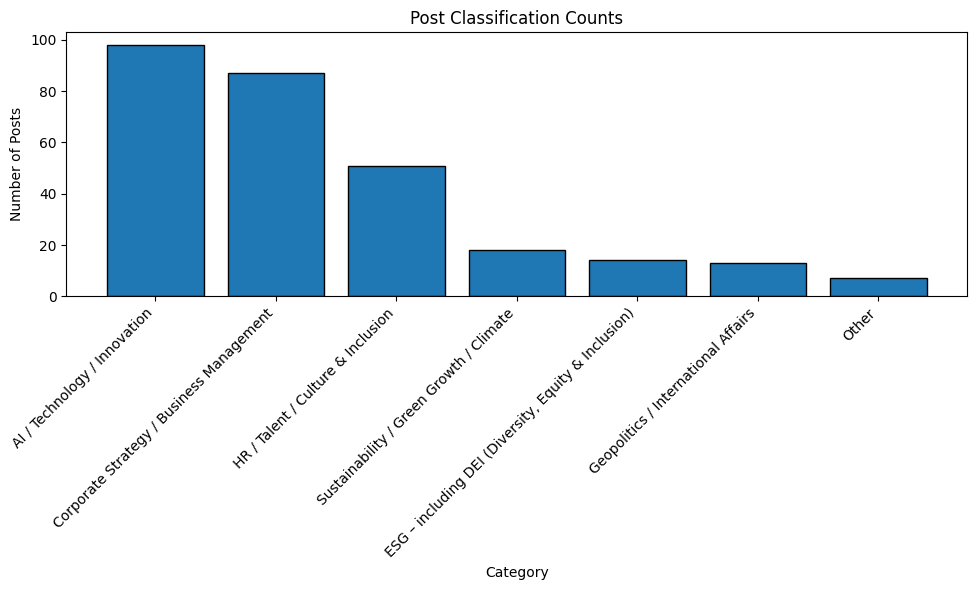

In [24]:
#visualise the results 

import matplotlib.pyplot as plt

# Count the categories
category_counts = df_mck_classified["ai_guess"].value_counts()

# Create bar chart manually for better alignment
plt.figure(figsize=(10, 6))
bars = plt.bar(category_counts.index, category_counts.values, edgecolor='black')

# Add labels and formatting
plt.title("Post Classification Counts")
plt.xlabel("Category")
plt.ylabel("Number of Posts")
plt.xticks(ticks=range(len(category_counts.index)), labels=category_counts.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()


<Figure size 1400x700 with 0 Axes>

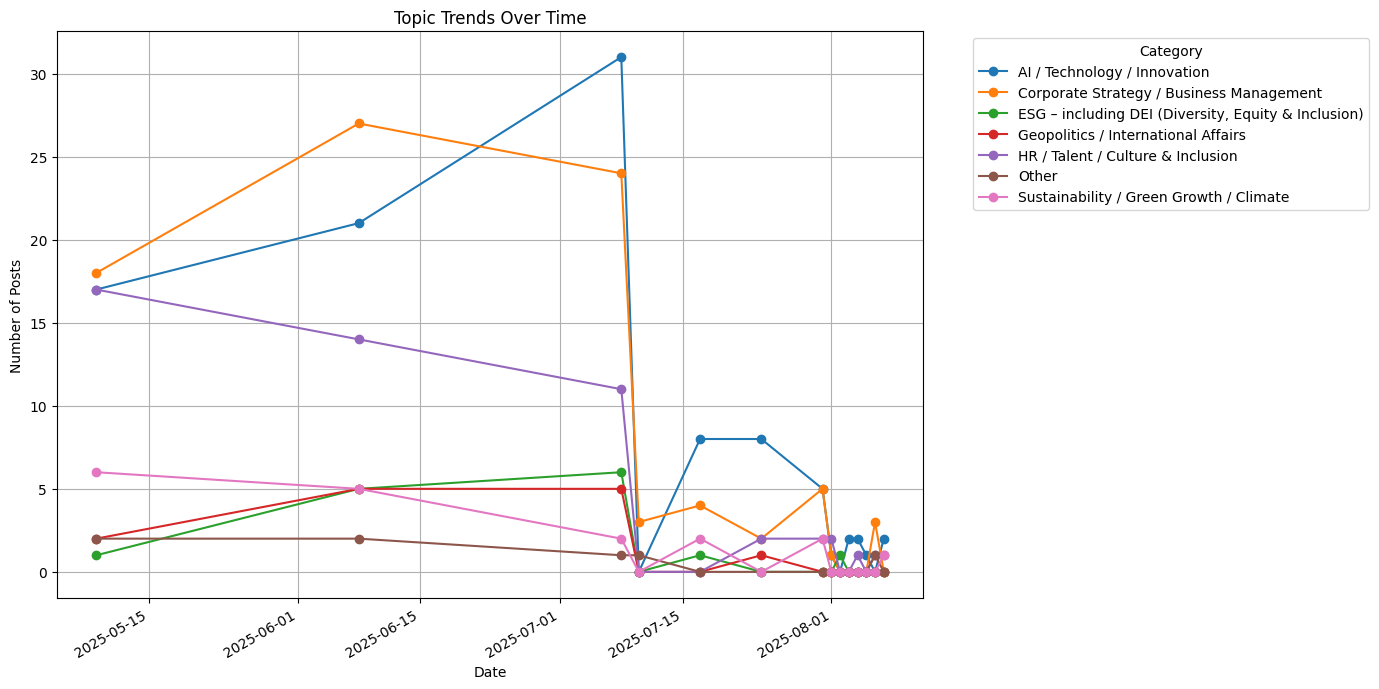

In [25]:
#trends over time 

import matplotlib.pyplot as plt

# Ensure normalized date is datetime
df_mck_classified["normalized_date"] = pd.to_datetime(df_mck_classified["normalized_date"])

# Group by date and category, then count
trend_data = df_mck_classified.groupby(["normalized_date", "ai_guess"]).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(14, 7))
trend_data.plot(kind='line', marker='o', figsize=(14, 7))

plt.title("Topic Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Posts")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

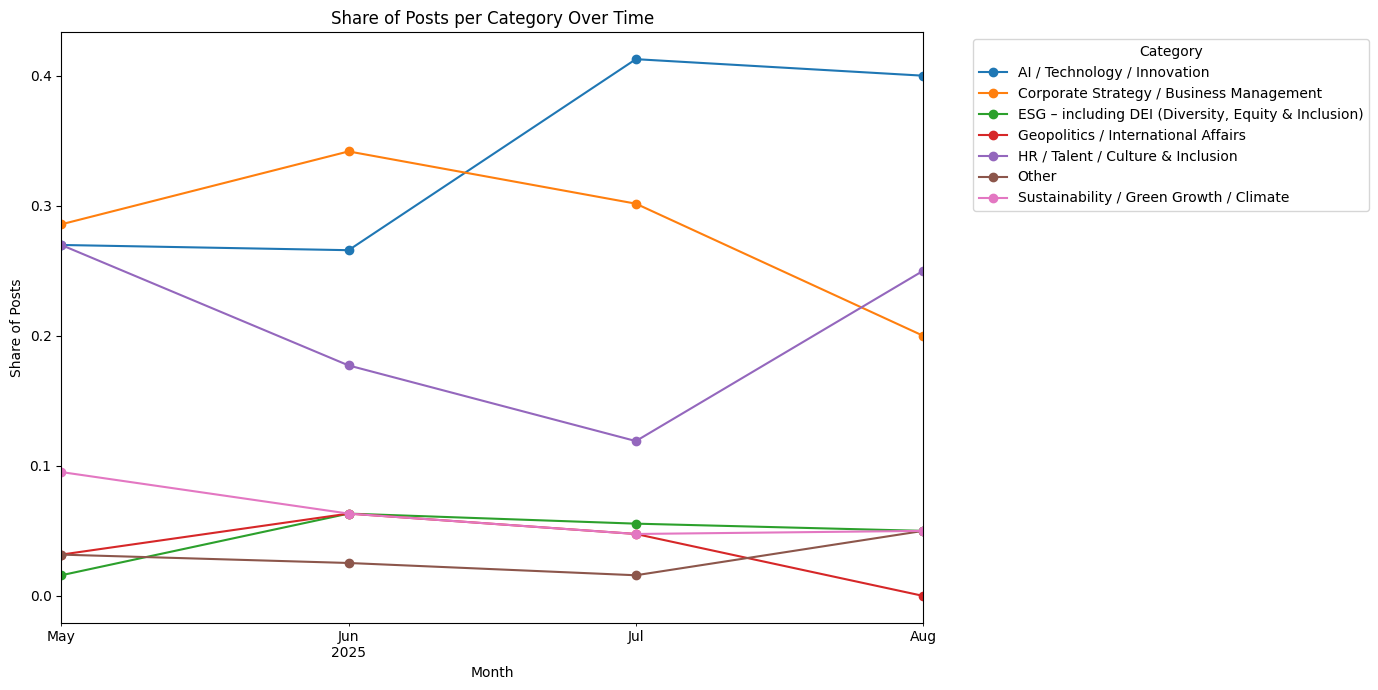

In [26]:
#what is the monthly share of posts in each category? 
df_mck_classified["month"] = df_mck_classified["normalized_date"].dt.to_period("M")

monthly_counts = df_mck_classified.groupby(["month", "ai_guess"]).size().unstack(fill_value=0)

monthly_shares = monthly_counts.div(monthly_counts.sum(axis=1), axis=0)

# Plot
monthly_shares.plot(figsize=(14, 7), marker='o')
plt.title("Share of Posts per Category Over Time")
plt.xlabel("Month")
plt.ylabel("Share of Posts")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [27]:
# monthly shares as percentages in table format 

df_mck_classified["month"] = df_mck_classified["normalized_date"].dt.to_period("M")

#Count posts by month and category
monthly_counts = df_mck_classified.groupby(["month", "ai_guess"]).size().unstack(fill_value=0)
monthly_total = monthly_counts.sum(axis=1)

#Calculate shares (in percentage)
monthly_shares_pct = monthly_counts.div(monthly_counts.sum(axis=1), axis=0) * 100
monthly_shares_pct = monthly_shares_pct.round(1)  # round to 1 decimal place
monthly_shares_pct["Total Posts"] = monthly_total

# Display as table
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)  # show all columns
display(monthly_shares_pct)

ai_guess,AI / Technology / Innovation,Corporate Strategy / Business Management,"ESG – including DEI (Diversity, Equity & Inclusion)",Geopolitics / International Affairs,HR / Talent / Culture & Inclusion,Other,Sustainability / Green Growth / Climate,Total Posts
month,,,,,,,,
2025-05,27.0,28.6,1.6,3.2,27.0,3.2,9.5,63
2025-06,26.6,34.2,6.3,6.3,17.7,2.5,6.3,79
2025-07,41.3,30.2,5.6,4.8,11.9,1.6,4.8,126
2025-08,40.0,20.0,5.0,0.0,25.0,5.0,5.0,20


In [29]:
#save as csv file 
df_mck_classified.to_csv("df_mck_classified.csv", index=False)
